## Full Run of the final prediction System

1. User input: Target Country
2. Clustering
3. Granger Causality Test
4. User Input: Available projections to be used (if any)
5. User Input: Prediction Horizon
6. Facebook Prophet for other countries, merge the results
7. Step wise prediction, one future period at a time 

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from fbprophet import Prophet
from time import time


from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr

from statsmodels.tsa.stattools import grangercausalitytests

**Converting the code to function**

In [44]:
def invert_transformation(df_train, df_forecast, second_diff=True):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

# Building App structure
------------------
------------------

1. Choose **target MEV** to predict/calculate: For instance GDP
2. Choose **target country**
3. Horizon of the prediction needed (How many n years/quarters in the future to predict)
4. Present a correlation/clusters The target country belong too, along with list of countries in the cluster
5. Filter out countries with **low predictive power** toward our target country
6. Retreive countrie' MEV projection available with user (for instance UK projection under stress scenario)
7. **Run first VAR to calculate C1 projection step 1**
8. Use FBProphet to predict n years, return smaller df with country's $\hat{y}$ n period in future
9. Merge it with:
  * users projection step 1 (to have first row of x_test)
  * target country's MEV predicted in (7)
10. Now we have the full row of step 1 (Target projection, user input projection and fbProphet first row). **Repeat 7,8 and 9 step wise until we have all projections**

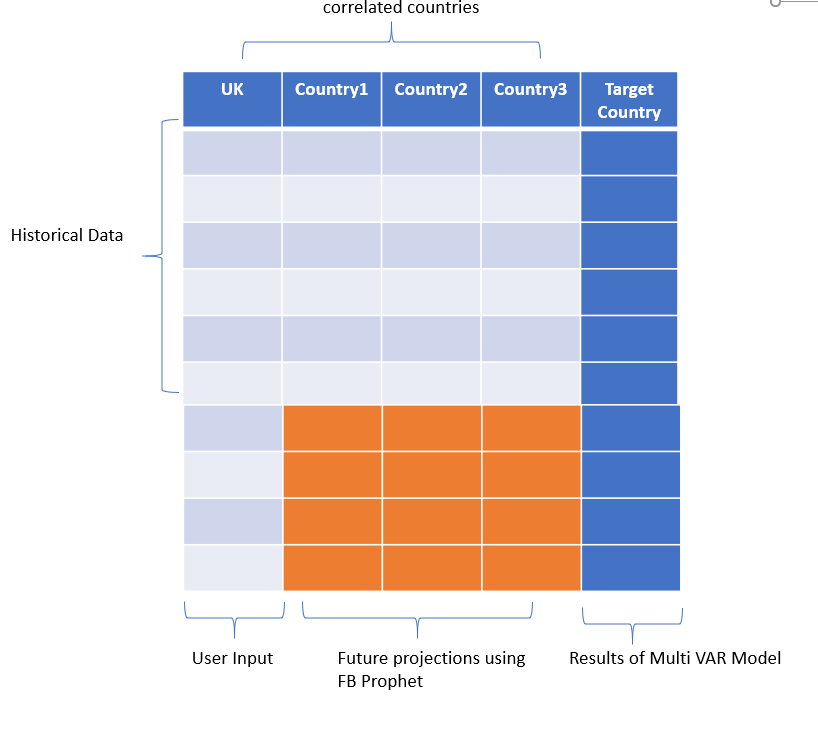

In [3]:
# 1. for now as test we will use GDP as target MEV
# 2. for now as test we will use Italy as C1 
# 3. Projection horizon is 5 years (since our data is in years)
# 4. 
# 5. for now as test we will use UK as C5

**Testing**

 1. GDP as target MEV
 2. Canada as Target County 
 3. Projection horizon is 3 years 
 5. UK as User Input (Available Projection to use)

In [147]:
gdp_df_imf = pd.read_excel('/content/gdp_imf_clustered.xlsx')

In [148]:
print('List of countries:\n',gdp_df_imf['country'].values.tolist())
target_country = input('\n\nWhich country you want to project or calculate the "GDP" to? write as in list above\n ').title()

List of countries:
 ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong SAR', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 

In [149]:
# get the cluster
target_cluster = gdp_df_imf[gdp_df_imf['country']==target_country]['Cluster'].values[0]
# get the target df
target_df = gdp_df_imf[gdp_df_imf['Cluster']==target_cluster]
# list of countries in the cluster
target_cluster_countries = target_df['country'].tolist()


print(f'{target_country} shares cluster {target_cluster} with:\n{target_cluster_countries}\n\n')



Canada shares cluster 3 with:
['Australia', 'Brazil', 'Canada', 'France', 'India', 'Indonesia', 'Italy', 'Korea', 'Mexico', 'Netherlands', 'Russia', 'Spain', 'Turkey', 'United Kingdom']




**Granger Causality Test**

In [234]:
# preprocessing the dataframe before running the prediction

processed_df = target_df.drop(columns='Cluster').T.reset_index()
processed_df.columns = processed_df.loc[0]
processed_df = processed_df.iloc[1:,:]
processed_df.rename(columns={"country": "year" }, inplace = True)
processed_df['year'] = pd.to_datetime(processed_df['year'], format='%Y')
#processed_df.head(2)

# Granger Causality Test
maxlag=12
test = 'ssr_ftest'

def grangers_causation_matrix(data, variables, test='ssr_ftest', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangMatrix = grangers_causation_matrix(processed_df.iloc[:,1:], variables = processed_df.iloc[:,1:].columns)


def style_negative(v, props=''):
    return props if v < 0 else None
    
#grangMatrix.style.applymap(lambda x: "background-color: #A10035" if x>0.05 else "background-color: #94B49F")

grangMatrix.style.applymap(style_negative, props='color:red;')\
              .applymap(lambda v: 'opacity: 20%;' if v > 0.05 else None).applymap(lambda x: "background-color: #A10035" if x>0.05 else None)

,Australia_x,Brazil_x,Canada_x,France_x,India_x,Indonesia_x,Italy_x,Korea_x,Mexico_x,Netherlands_x,Russia_x,Spain_x,Turkey_x,United Kingdom_x
Australia_y,1.000000,0.123000,0.002700,0.035900,0.006000,0.020000,0.046900,0.010700,0.000300,0.006500,0.010600,0.001800,0.187900,0.002600
Brazil_y,0.009100,1.000000,0.000200,0.003800,0.000600,0.001100,0.003600,0.009900,0.002400,0.000700,0.003500,0.000100,0.025900,0.000200
Canada_y,0.042900,0.017300,1.000000,0.175700,0.110700,0.002000,0.233900,0.004100,0.002900,0.032600,0.003600,0.056800,0.089400,0.018400
France_y,0.322100,0.015500,0.100400,1.000000,0.057200,0.206400,0.226200,0.038300,0.015900,0.083800,0.077500,0.040800,0.324700,0.000000
India_y,0.052500,0.005200,0.001600,0.037900,1.000000,0.567000,0.049800,0.000400,0.000200,0.003400,0.007300,0.008000,0.017800,0.000000
Indonesia_y,0.108900,0.088400,0.019400,0.022800,0.024800,1.000000,0.010900,0.002200,0.003600,0.009800,0.108500,0.002000,0.008700,0.000800
Italy_y,0.512100,0.121700,0.275000,0.218300,0.073100,0.404600,1.000000,0.100300,0.035000,0.356900,0.087100,0.104700,0.184200,0.003700
Korea_y,0.571500,0.674500,0.229300,0.097700,0.639000,0.359200,0.269700,1.000000,0.015500,0.333300,0.268700,0.243200,0.295700,0.041600
Mexico_y,0.185800,0.276100,0.115200,0.026100,0.195900,0.087600,0.012500,0.092500,1.000000,0.021600,0.331200,0.028900,0.335200,0.018000
Netherlands_y,0.314200,0.012200,0.103800,0.156500,0.025800,0.135400,0.626700,0.008200,0.003500,1.000000,0.066000,0.118300,0.160600,0.000000


In [151]:
user_choice = input('Do you want to provide projections for one of the countries? answer with yes or no\n ').lower()

countries_to_drop = []
countries_to_drop.append(target_country)

countries_to_predict = []

if user_choice == 'no':
  print('No Country Provided, we will predict them all💪\n')
  #countries_to_predict = [c for c in target_cluster_countries if c != countries_to_drop]
else:
  user_input_country = input('What country you have projection to? write the name as in list above!\n ').title()
  if user_input_country not in target_cluster_countries:
    print(f'country you provide {user_input_country} is not in the list of countries in cluster {target_cluster}\nOr its not written correctly')
  else:
    countries_to_drop.append(user_input_country)
    #countries_to_predict = [c for c in target_cluster_countries if c not in countries_to_drop]



countries_to_predict = [c for c in target_cluster_countries if c not in countries_to_drop]

print(f'Countries we will run prediction to:\n{countries_to_predict}')

Do you want to provide projections for one of the countries? answer with yes or no
 yes
What country you have projection to? write the name as in list above!
 italy
Countries we will run prediction to:
['Australia', 'Brazil', 'France', 'India', 'Indonesia', 'Korea', 'Mexico', 'Netherlands', 'Russia', 'Spain', 'Turkey', 'United Kingdom']


In [152]:
prediction_horizon = int(input('How many years in the future you want to predict? \n'))

How many years in the future you want to predict? 
3


**Facebook Projection**

In [153]:
# predicting fbProphet 

prediction_df = pd.DataFrame()

for i in processed_df[countries_to_predict].columns:
  df = processed_df[['year',i]]
  df.columns = ['ds','y']
  m = Prophet(seasonality_mode='multiplicative')
  m.fit(df)
  future = m.make_future_dataframe(periods=prediction_horizon,freq='A')
  forecast = m.predict(future)[['ds', 'yhat']]
  #print(forecast)
  prediction_df[i] = forecast.iloc[:, 1]
  prediction_df['ds'] = forecast.iloc[:, 0]



prediction_df.tail() 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,Australia,ds,Brazil,France,India,Indonesia,Korea,Mexico,Netherlands,Russia,Spain,Turkey,United Kingdom
40,1437.543352,2020-01-01,2054.289854,2686.858680,2839.294073,951.587889,1688.369721,1288.503454,983.585960,1805.302770,1554.750932,884.959512,2855.261924
41,1507.329148,2021-01-01,2170.368174,2737.841751,3095.087147,986.378530,1813.141285,1350.153518,1003.503093,1928.849865,1587.216736,899.743794,2913.113337
42,1497.129519,2021-12-31,2086.438634,2655.008195,3016.764055,1007.428074,1726.288691,1284.088219,1018.944772,1861.028470,1607.256896,934.743546,2838.286131
43,1527.985727,2022-12-31,2089.596281,2636.205821,3096.028402,1037.669716,1741.003450,1266.065611,1032.994706,1884.683743,1625.936578,958.947118,2826.537378
44,1559.669035,2023-12-31,2083.586120,2615.510132,3168.699943,1069.606365,1752.810348,1236.795488,1044.455286,1905.443985,1639.205340,982.638744,2812.619103


In [154]:
all_numbers = []
for i in range(prediction_horizon):
  inp = int(input(f'Add the projection GDP numbers {i} of {user_input_country}:'))
  all_numbers.append(inp)


all_numbers = pd.Series(all_numbers)

user_full_projection = processed_df[user_input_country].append(all_numbers).reset_index(drop=True)

Add the projection GDP numbers 0 of Italy:750
Add the projection GDP numbers 1 of Italy:800
Add the projection GDP numbers 2 of Italy:850


---
**Merge with Patrizia VAR model, and Step wise Prediction**

In [155]:
for i in processed_df.columns:
  if i != 'year':
    processed_df[i] = processed_df[i].astype(float)

In [156]:
#processed_df[target_cluster_countries].head()

df_p = processed_df.copy().set_index('year')
# first and second diff
df_differenced = df_p.diff().dropna()
df_differenced = df_differenced.diff().dropna()

#df_differenced.head()

model = VAR(df_differenced)

model_fitted = model.fit(5)
model_fitted.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/var_model.py:1431: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self._cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 22, Jul, 2022
Time:                     12:27:55
--------------------------------------------------------------------
No. of Equations:         14.0000    BIC:                   -719.196
Nobs:                     35.0000    HQIC:                  -748.120
Log likelihood:           13657.7    FPE:                    0.00000
AIC:                     -763.368    Det(Omega_mle):         0.00000
--------------------------------------------------------------------
Results for equation Australia
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.011231              NAN              NAN             NAN
L1.Australia              0.328171              NAN              NAN             NAN
L1.Brazil                -0.357282      

In [157]:
df2 =df_p.reset_index()
prediction_start_year = (df2["year"].iloc[-2] + pd.DateOffset(years=1)).strftime('%Y-%m-%d')
prediction_date_range = pd.date_range(prediction_start_year,periods=1,freq='A')


forecast_input = df_differenced.values
fc = model_fitted.forecast(y=forecast_input, steps=1)


df_forecast = pd.DataFrame(fc,columns=df_p.columns)
df_forecast.index = prediction_date_range


df_results = invert_transformation(df_p, df_forecast, second_diff=True) 
target_country_var = df_results[['Canada_forecast']]
target_country_var.columns = ['Canada']

df_p = df_p.append(target_country_var)
df_p.tail()

,Australia,Brazil,Canada,France,India,Indonesia,Italy,Korea,Mexico,Netherlands,Russia,Spain,Turkey,United Kingdom
2018-01-01,1421.30,1916.93,1721.820000,2791.16,2701.11,1042.71,2093.09,1725.37,1222.35,914.458,1653.01,1422.80,779.599,2860.98
2019-01-01,1391.54,1877.11,1741.580000,2717.20,2870.50,1120.04,2005.14,1646.74,1268.87,907.151,1689.30,1393.64,760.940,2833.30
2020-01-01,1359.33,1434.08,1643.410000,2598.91,2708.77,1059.64,1884.94,1630.87,1076.16,909.503,1473.58,1278.21,719.537,2710.97
2021-01-01,1617.54,1491.77,1883.490000,2938.27,3049.70,1158.78,2106.29,1806.71,1192.48,1012.600,1710.73,1461.55,794.530,3124.65
2021-12-31,NaN,NaN,2208.872488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
# first Step

#name = target_country+ '_target'



## Patrizia's code
patrizia = df_p[target_country].reset_index(drop=True)

# # add it to series to be merged later
patrizia = pd.Series(patrizia[:],name=target_country)


# fbPrediction
fb = prediction_df.drop(columns='ds').iloc[:-prediction_horizon+1,:]


# user projection
user = pd.Series(user_full_projection[:-prediction_horizon+1],name=user_input_country)
#type(user_full_projection)

# concat them
#user_provide = user_input_country + '_user'

first_step_df = pd.concat([patrizia, fb,user], axis=1)

# #first_step_df = first_step_df.rename(columns = {target_country:name})
# #first_step_df = first_step_df.rename(columns = {user_input_country:user_provide})

first_step_df.tail()

,Canada,Australia,Brazil,France,India,Indonesia,Korea,Mexico,Netherlands,Russia,Spain,Turkey,United Kingdom,Italy
38,1721.820000,1380.190381,1990.653544,2710.937056,2638.091349,901.173703,1639.575538,1254.472906,939.443866,1738.866019,1483.956960,833.612156,2863.548772,2093.09
39,1741.580000,1408.633235,2026.177845,2699.875650,2741.539020,925.761160,1665.296110,1276.004853,962.543538,1773.382246,1521.492454,859.460484,2860.489545,2005.14
40,1643.410000,1437.543352,2054.289854,2686.858680,2839.294073,951.587889,1688.369721,1288.503454,983.585960,1805.302770,1554.750932,884.959512,2855.261924,1884.94
41,1883.490000,1507.329148,2170.368174,2737.841751,3095.087147,986.378530,1813.141285,1350.153518,1003.503093,1928.849865,1587.216736,899.743794,2913.113337,2106.29
42,2208.872488,1497.129519,2086.438634,2655.008195,3016.764055,1007.428074,1726.288691,1284.088219,1018.944772,1861.028470,1607.256896,934.743546,2838.286131,750


In [159]:
for i in first_step_df.columns:
  if i != 'year':
    first_step_df[i] = first_step_df[i].astype(float)

In [160]:

df_p2 = first_step_df.copy()
df_p2.index = df_p.index

# first and second diff
df_differenced2 = df_p2.diff().dropna()
df_differenced2 = df_differenced2.diff().dropna()

#df_differenced.head()

model2 = VAR(df_differenced2)

model_fitted2 = model2.fit(5)



df3 =df_p2.reset_index()
prediction_start_year2 = (df3["index"].iloc[-2] + pd.DateOffset(years=1)).strftime('%Y-%m-%d')
prediction_date_range2 = pd.date_range(prediction_start_year2,periods=1,freq='A')


forecast_input2 = df_differenced2.values
fc2 = model_fitted2.forecast(y=forecast_input2, steps=1)


df_forecast2 = pd.DataFrame(fc2,columns=df_p2.columns)
df_forecast2.index = prediction_date_range2


df_results2 = invert_transformation(df_p2, df_forecast2, second_diff=True) 
target_country_var2 = df_results2[['Canada_forecast']]
target_country_var2.columns = ['Canada']

df_p2 = df_p2.append(target_country_var2)
df_p2.tail()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,Canada,Australia,Brazil,France,India,Indonesia,Korea,Mexico,Netherlands,Russia,Spain,Turkey,United Kingdom,Italy
2019-01-01,1741.580000,1408.633235,2026.177845,2699.875650,2741.539020,925.761160,1665.296110,1276.004853,962.543538,1773.382246,1521.492454,859.460484,2860.489545,2005.14
2020-01-01,1643.410000,1437.543352,2054.289854,2686.858680,2839.294073,951.587889,1688.369721,1288.503454,983.585960,1805.302770,1554.750932,884.959512,2855.261924,1884.94
2021-01-01,1883.490000,1507.329148,2170.368174,2737.841751,3095.087147,986.378530,1813.141285,1350.153518,1003.503093,1928.849865,1587.216736,899.743794,2913.113337,2106.29
2021-12-31,2208.872488,1497.129519,2086.438634,2655.008195,3016.764055,1007.428074,1726.288691,1284.088219,1018.944772,1861.028470,1607.256896,934.743546,2838.286131,750.00
2022-12-31,1043.416743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
# # second Step
# name = target_country+ '_target'



## Patrizia's code
#patrizia = [1000,1500]
patrizia = df_p2[target_country].reset_index(drop=True)
# # add it to series to be merged later
patrizia = pd.Series(patrizia[:],name=target_country)
# target_projection = processed_df[target_country].append(patrizia).reset_index(drop=True)


# fbPrediction
fb = prediction_df.drop(columns='ds').iloc[:-prediction_horizon+2,:]

# user projection
user = pd.Series(user_full_projection[:-prediction_horizon+2],name=user_input_country)
#type(user_full_projection)
# concat them

#user_provide = user_input_country + '_user'

second_step_df = pd.concat([patrizia,fb, user], axis=1)

# second_step_df = second_step_df.rename(columns = {target_country:name})
# second_step_df = second_step_df.rename(columns = {user_input_country:user_provide})


second_step_df.tail()

,Canada,Australia,Brazil,France,India,Indonesia,Korea,Mexico,Netherlands,Russia,Spain,Turkey,United Kingdom,Italy
39,1741.580000,1408.633235,2026.177845,2699.875650,2741.539020,925.761160,1665.296110,1276.004853,962.543538,1773.382246,1521.492454,859.460484,2860.489545,2005.14
40,1643.410000,1437.543352,2054.289854,2686.858680,2839.294073,951.587889,1688.369721,1288.503454,983.585960,1805.302770,1554.750932,884.959512,2855.261924,1884.94
41,1883.490000,1507.329148,2170.368174,2737.841751,3095.087147,986.378530,1813.141285,1350.153518,1003.503093,1928.849865,1587.216736,899.743794,2913.113337,2106.29
42,2208.872488,1497.129519,2086.438634,2655.008195,3016.764055,1007.428074,1726.288691,1284.088219,1018.944772,1861.028470,1607.256896,934.743546,2838.286131,750
43,1043.416743,1527.985727,2089.596281,2636.205821,3096.028402,1037.669716,1741.003450,1266.065611,1032.994706,1884.683743,1625.936578,958.947118,2826.537378,800


In [162]:
for i in second_step_df.columns:
  if i != 'year':
    second_step_df[i] = second_step_df[i].astype(float)

In [163]:

df_p3 = second_step_df.copy()
df_p3.index = df_p2.index

# first and second diff
df_differenced3 = df_p3.diff().dropna()
df_differenced3 = df_differenced3.diff().dropna()

#df_differenced.head()

model3 = VAR(df_differenced3)

model_fitted3 = model3.fit(5)



df4 =df_p3.reset_index()
prediction_start_year3 = (df4["index"].iloc[-2] + pd.DateOffset(years=1)).strftime('%Y-%m-%d')
prediction_date_range3 = pd.date_range(prediction_start_year3,periods=1,freq='A')


forecast_input3 = df_differenced3.values
fc3 = model_fitted3.forecast(y=forecast_input3, steps=1)


df_forecast3 = pd.DataFrame(fc3,columns=df_p3.columns)
df_forecast3.index = prediction_date_range3


df_results3 = invert_transformation(df_p3, df_forecast3, second_diff=True) 
target_country_var3 = df_results3[['Canada_forecast']]
target_country_var3.columns = ['Canada']

df_p3 = df_p3.append(target_country_var3)
df_p3.tail()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,Canada,Australia,Brazil,France,India,Indonesia,Korea,Mexico,Netherlands,Russia,Spain,Turkey,United Kingdom,Italy
2020-01-01,1643.410000,1437.543352,2054.289854,2686.858680,2839.294073,951.587889,1688.369721,1288.503454,983.585960,1805.302770,1554.750932,884.959512,2855.261924,1884.94
2021-01-01,1883.490000,1507.329148,2170.368174,2737.841751,3095.087147,986.378530,1813.141285,1350.153518,1003.503093,1928.849865,1587.216736,899.743794,2913.113337,2106.29
2021-12-31,2208.872488,1497.129519,2086.438634,2655.008195,3016.764055,1007.428074,1726.288691,1284.088219,1018.944772,1861.028470,1607.256896,934.743546,2838.286131,750.00
2022-12-31,1043.416743,1527.985727,2089.596281,2636.205821,3096.028402,1037.669716,1741.003450,1266.065611,1032.994706,1884.683743,1625.936578,958.947118,2826.537378,800.00
2022-12-31,3012.313313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
# third Step
#name = target_country+ '_target'
## Patrizia's code
patrizia = df_p3[target_country].reset_index(drop=True)
# add it to series to be merged later
patrizia = pd.Series(patrizia[:],name=target_country)
#target_projection = processed_df[target_country].append(patrizia).reset_index(drop=True)


# fbPrediction
fb = prediction_df.drop(columns='ds').iloc[:,:]

# user projection
user = pd.Series(user_full_projection[:],name=user_input_country)
#type(user_full_projection)
# concat them
#user_provide = user_input_country + '_user'
third_step_df = pd.concat([patrizia,fb, user], axis=1)

# third_step_df = third_step_df.rename(columns = {target_country:name})
# third_step_df = third_step_df.rename(columns = {user_input_country:user_provide})


third_step_df.tail()

,Canada,Australia,Brazil,France,India,Indonesia,Korea,Mexico,Netherlands,Russia,Spain,Turkey,United Kingdom,Italy
40,1643.410000,1437.543352,2054.289854,2686.858680,2839.294073,951.587889,1688.369721,1288.503454,983.585960,1805.302770,1554.750932,884.959512,2855.261924,1884.94
41,1883.490000,1507.329148,2170.368174,2737.841751,3095.087147,986.378530,1813.141285,1350.153518,1003.503093,1928.849865,1587.216736,899.743794,2913.113337,2106.29
42,2208.872488,1497.129519,2086.438634,2655.008195,3016.764055,1007.428074,1726.288691,1284.088219,1018.944772,1861.028470,1607.256896,934.743546,2838.286131,750
43,1043.416743,1527.985727,2089.596281,2636.205821,3096.028402,1037.669716,1741.003450,1266.065611,1032.994706,1884.683743,1625.936578,958.947118,2826.537378,800
44,3012.313313,1559.669035,2083.586120,2615.510132,3168.699943,1069.606365,1752.810348,1236.795488,1044.455286,1905.443985,1639.205340,982.638744,2812.619103,850


---
# Next Step & Recommendation:

* Automise the selection of coefficient p_Value below threshold (use Granger Causality test to pick counties and their Lag that is below threshold)
* Streamline the full code, make the prediction automatic and interactive (WebApp)
* Define performace metrics to measure the accuracy

# End